In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Custom loader to handle corrupted images
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping corrupted image: {path}")
        return None

train_dir = '/home/arnav/Documents/research_project/assignment01/images/train'
test_dir = '/home/arnav/Documents/research_project/assignment01/images/test'
val_dir = '/home/arnav/Documents/research_project/assignment01/images/val'

transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(), #Convert a PIL Image or ndarray to tensor and scale the values accordingly, this transformation scales the pixel values from the range [0, 255] to the range [0, 1].
                               transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) #Normalize a tensor image with mean and standard deviation. Mean normalization: Subtracts the mean value from each channel (R, G, B) of the image tensor.Standard deviation normalization: Divides each channel by its standard deviation.

train_data = datasets.ImageFolder(root= train_dir, transform=transform, loader= safe_loader)
test_data = datasets.ImageFolder(root= test_dir, transform=transform, loader = safe_loader)
val_data = datasets.ImageFolder(root= val_dir, transform=transform, loader = safe_loader)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(64*64*3, 84) #first layer
        self.l2 = nn.Linear(84, 50)
        self.l3 = nn.Linear(50,2)
        self.relu = nn.ReLU() #Rectified Linear Units: activation function. simply returns max(0,x)

    def forward(self, x):
        x= x.view(x.size(0), -1) # reshapes the input tensor to have the shape (batch_size, num_features), where num_features is the product of the dimensions of the image.
        x = self.relu(self.l1(x)) #pass the flattened input through first layer
        x = self.relu(self.l2(x))
        x = self.l3(x) # passes the output of the second layer through the third fully connected layer, This layer does not have an activation function applied, as it directly outputs the raw scores (logits) for the two classes (cat and fish)

        return x  

from torchvision.models import alexnet

class CustomAlexNet(nn.Module):
    def __init__(self):
        super(CustomAlexNet, self).__init__()
        self.alexnet = alexnet(pretrained=False)
        self.alexnet.classifier[6] = nn.Linear(4096, 2)#replaced the 6th and final layer of the alexnet classifier with a layer that outputs 2 classes (cat and fish)
        
    def forward(self, x):
        return self.alexnet(x)




def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=25, device="cpu"):
    model.to(device)
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        
        model.train()  # Setting the model to train mode
        training_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Set gradient to zero
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
            training_loss += loss.item()  # Loss.item() converts the loss tensor to a standard Python number (float)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(training_loss / len(train_loader))

        model.eval()  # Setting the model to validation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation during validation, which saves memory and computation time
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss: {training_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f"Average Training Accuracy over {epochs} epochs: {avg_train_accuracy}")
    print(f"Average Validation Accuracy over {epochs} epochs: {avg_val_accuracy}")

    # Plotting accuracies and losses
    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def test(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {accuracy}")


for 25 epochs:

Epoch 1: Train Loss: 0.5544764087313697, Train Accuracy: 0.6945288753799392, Val Loss: 0.4446062871388027, Val Accuracy: 0.7917933130699089
Epoch 2: Train Loss: 0.4474175033115205, Train Accuracy: 0.7933130699088146, Val Loss: 0.37372984843594687, Val Accuracy: 0.8480243161094225
Epoch 3: Train Loss: 0.36287093304452445, Train Accuracy: 0.851063829787234, Val Loss: 0.30613323691345395, Val Accuracy: 0.8860182370820668
Epoch 4: Train Loss: 0.3025266897110712, Train Accuracy: 0.8890577507598785, Val Loss: 0.2552233991168794, Val Accuracy: 0.9270516717325228
Epoch 5: Train Loss: 0.25604080728122164, Train Accuracy: 0.9164133738601824, Val Loss: 0.21456427162601835, Val Accuracy: 0.9407294832826748
Epoch 6: Train Loss: 0.22215389744156883, Train Accuracy: 0.9452887537993921, Val Loss: 0.18619706020468757, Val Accuracy: 0.958966565349544
Epoch 7: Train Loss: 0.1893122387783868, Train Accuracy: 0.952887537993921, Val Loss: 0.15494677814699354, Val Accuracy: 0.9741641337386018
Epoch 8: Train 

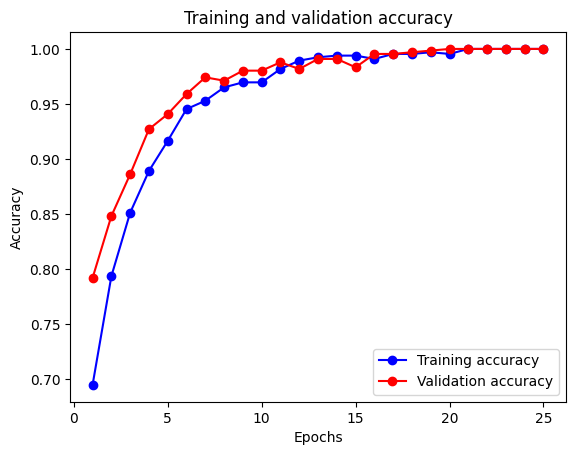

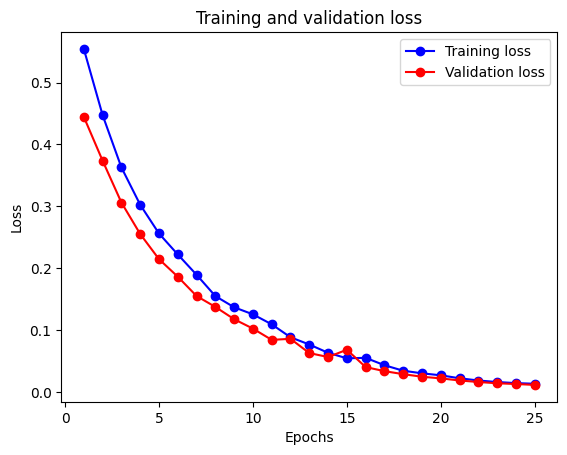

Test Loss: 0.8103308253921568, Test Accuracy: 0.7484662576687117


/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th

Epoch 1: Train Loss: 0.6563976321901593, Train Accuracy: 0.5835866261398176, Val Loss: 0.5894000998565129, Val Accuracy: 0.5866261398176292
Epoch 2: Train Loss: 0.5414980564798627, Train Accuracy: 0.7127659574468085, Val Loss: 0.4400653839111328, Val Accuracy: 0.8191489361702128
Epoch 3: Train Loss: 0.4556304649228141, Train Accuracy: 0.8100303951367781, Val Loss: 0.38460291070597513, Val Accuracy: 0.817629179331307
Epoch 4: Train Loss: 0.3909201487189248, Train Accuracy: 0.8343465045592705, Val Loss: 0.35672072427613394, Val Accuracy: 0.8601823708206687
Epoch 5: Train Loss: 0.35147144326141905, Train Accuracy: 0.8556231003039514, Val Loss: 0.26196015785847393, Val Accuracy: 0.8936170212765957
Epoch 6: Train Loss: 0.28817430564335417, Train Accuracy: 0.8844984802431611, Val Loss: 0.20353176515726817, Val Accuracy: 0.9285714285714286
Epoch 7: Train Loss: 0.2107251655487787, Train Accuracy: 0.9270516717325228, Val Loss: 0.28764095521044164, Val Accuracy: 0.878419452887538
Epoch 8: Train 

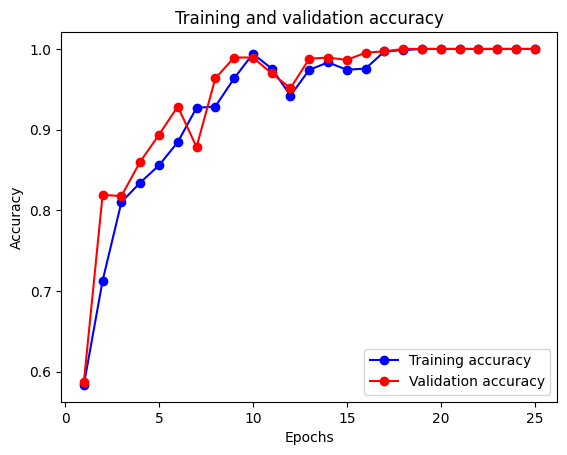

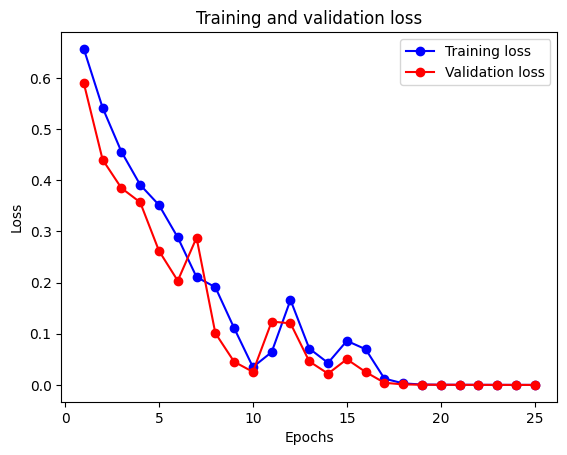

Test Loss: 1.394090491735066, Test Accuracy: 0.7852760736196319


In [3]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)


for 50 epochs:

Epoch 1: Train Loss: 0.5625343791076115, Train Accuracy: 0.7203647416413373, Val Loss: 0.45820548846608117, Val Accuracy: 0.8039513677811551
Epoch 2: Train Loss: 0.43384594150951933, Train Accuracy: 0.8115501519756839, Val Loss: 0.35907616856552305, Val Accuracy: 0.8647416413373861
Epoch 3: Train Loss: 0.3565536638100942, Train Accuracy: 0.8677811550151976, Val Loss: 0.3039183950140363, Val Accuracy: 0.9027355623100304
Epoch 4: Train Loss: 0.30927962561448413, Train Accuracy: 0.8936170212765957, Val Loss: 0.2584151157311031, Val Accuracy: 0.9088145896656535
Epoch 5: Train Loss: 0.2605737696091334, Train Accuracy: 0.9194528875379939, Val Loss: 0.21876496857120878, Val Accuracy: 0.9483282674772037
Epoch 6: Train Loss: 0.2261744581517719, Train Accuracy: 0.9422492401215805, Val Loss: 0.1848805309051559, Val Accuracy: 0.9574468085106383
Epoch 7: Train Loss: 0.20084437018349058, Train Accuracy: 0.9468085106382979, Val Loss: 0.16881718131757917, Val Accuracy: 0.9650455927051672
Epoch 8: Trai

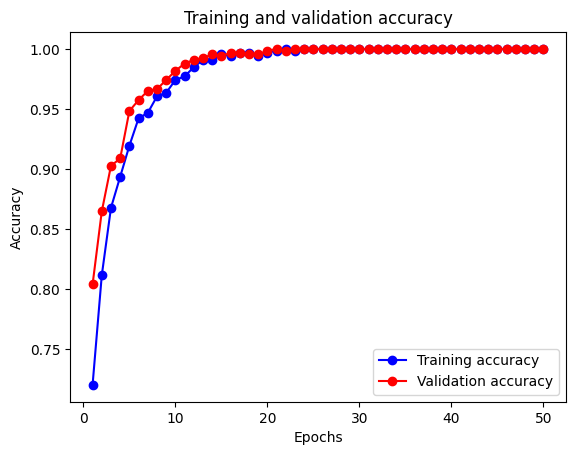

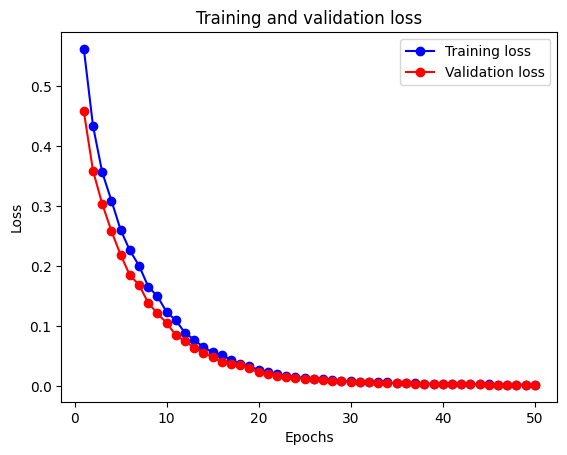

Test Loss: 1.0637476208309333, Test Accuracy: 0.7668711656441718
Epoch 1: Train Loss: 0.6462041622116452, Train Accuracy: 0.5881458966565349, Val Loss: 0.582127068723951, Val Accuracy: 0.6960486322188449
Epoch 2: Train Loss: 0.5595685797078269, Train Accuracy: 0.6884498480243161, Val Loss: 0.4664416228021894, Val Accuracy: 0.8161094224924013
Epoch 3: Train Loss: 0.4776865371635982, Train Accuracy: 0.7796352583586627, Val Loss: 0.45497278230530874, Val Accuracy: 0.8556231003039514
Epoch 4: Train Loss: 0.41718787380627226, Train Accuracy: 0.8100303951367781, Val Loss: 0.38602099212862195, Val Accuracy: 0.8161094224924013
Epoch 5: Train Loss: 0.36658344311373575, Train Accuracy: 0.8465045592705167, Val Loss: 0.2929340395189467, Val Accuracy: 0.8814589665653495
Epoch 6: Train Loss: 0.3101300292071842, Train Accuracy: 0.8708206686930091, Val Loss: 0.21553715460357212, Val Accuracy: 0.9224924012158054
Epoch 7: Train Loss: 0.21998547194969087, Train Accuracy: 0.9179331306990881, Val Loss: 0.1

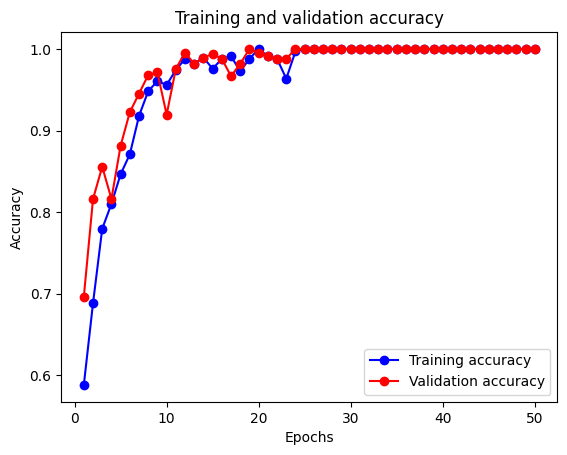

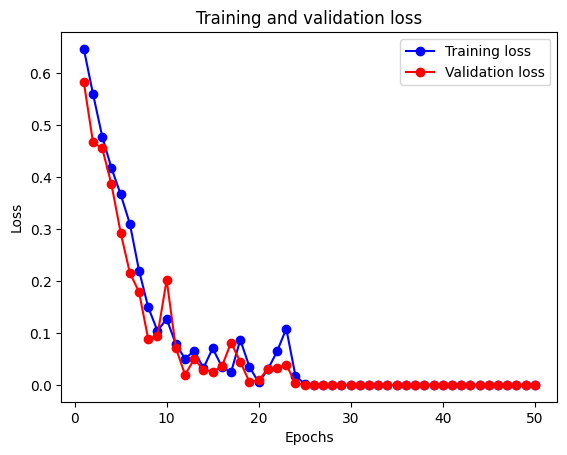

Test Loss: 2.0319275657335916, Test Accuracy: 0.7791411042944786


In [4]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=50, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=50, device=device)
test(alex_net, test_loader, device=device)


Epoch 1: Train Loss: 0.5905821933632805, Train Accuracy: 0.662613981762918, Val Loss: 0.4679233914329892, Val Accuracy: 0.7872340425531915
Epoch 2: Train Loss: 0.46558334146227154, Train Accuracy: 0.78419452887538, Val Loss: 0.38847648529779344, Val Accuracy: 0.8297872340425532
Epoch 3: Train Loss: 0.38510220107578097, Train Accuracy: 0.831306990881459, Val Loss: 0.32887495841298786, Val Accuracy: 0.8799392097264438
Epoch 4: Train Loss: 0.3315087954203288, Train Accuracy: 0.8647416413373861, Val Loss: 0.27494668321950094, Val Accuracy: 0.9133738601823708
Epoch 5: Train Loss: 0.27905697127183277, Train Accuracy: 0.9148936170212766, Val Loss: 0.23918952473572322, Val Accuracy: 0.939209726443769
Epoch 6: Train Loss: 0.23621728945346104, Train Accuracy: 0.9300911854103343, Val Loss: 0.1953478679060936, Val Accuracy: 0.9559270516717325
Epoch 7: Train Loss: 0.19578276113385246, Train Accuracy: 0.952887537993921, Val Loss: 0.18958208248728797, Val Accuracy: 0.952887537993921
Epoch 8: Train Lo

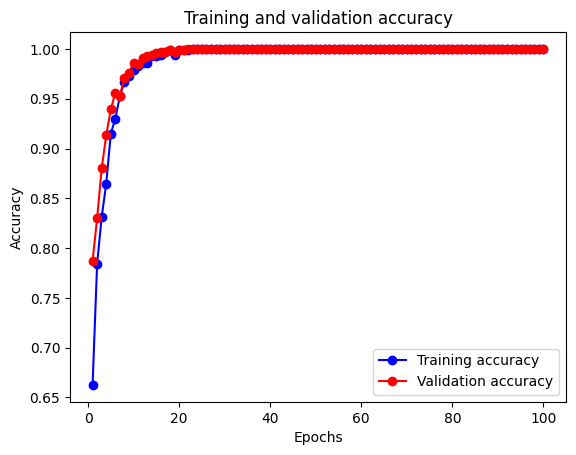

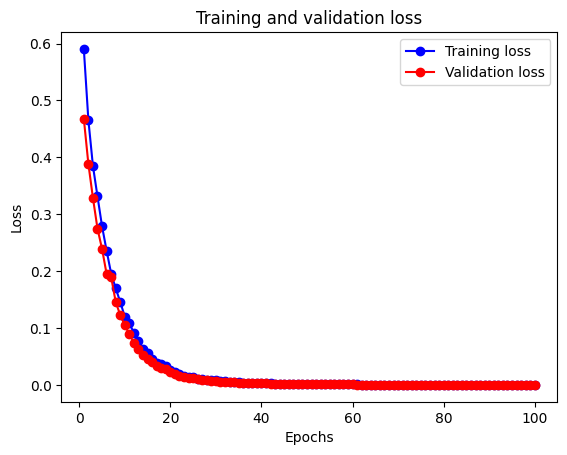

Test Loss: 1.28938503167592, Test Accuracy: 0.7730061349693251
Epoch 1: Train Loss: 0.6308135574772245, Train Accuracy: 0.5820668693009119, Val Loss: 0.5314208340077173, Val Accuracy: 0.7689969604863222
Epoch 2: Train Loss: 0.4917966680867331, Train Accuracy: 0.7735562310030395, Val Loss: 0.4090038985013962, Val Accuracy: 0.8024316109422492
Epoch 3: Train Loss: 0.3904700208277929, Train Accuracy: 0.8206686930091185, Val Loss: 0.32612939711127964, Val Accuracy: 0.8541033434650456
Epoch 4: Train Loss: 0.36814439935343607, Train Accuracy: 0.8753799392097265, Val Loss: 0.32601321524097804, Val Accuracy: 0.8525835866261399
Epoch 5: Train Loss: 0.3545324369555428, Train Accuracy: 0.8358662613981763, Val Loss: 0.24767340435868218, Val Accuracy: 0.8966565349544073
Epoch 6: Train Loss: 0.22646711376451312, Train Accuracy: 0.9072948328267477, Val Loss: 0.25894104760317577, Val Accuracy: 0.8875379939209727
Epoch 7: Train Loss: 0.2571926177257583, Train Accuracy: 0.9072948328267477, Val Loss: 0.17

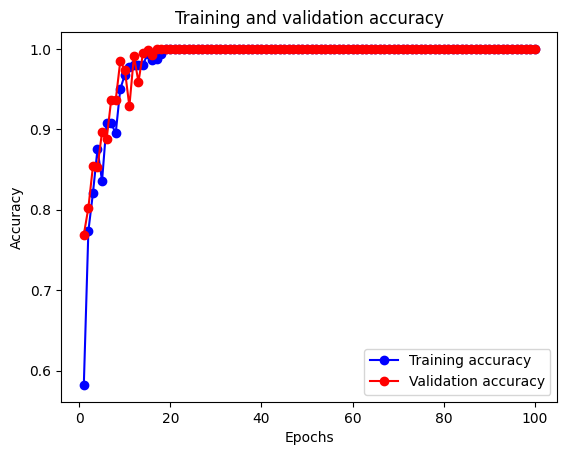

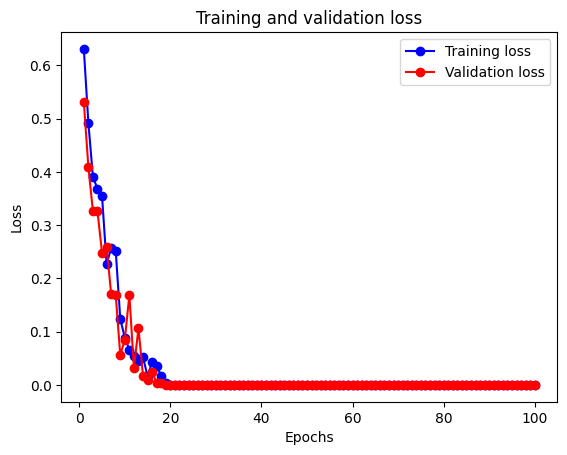

Test Loss: 2.4599660535653434, Test Accuracy: 0.7423312883435583


In [5]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=100, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=100, device=device)
test(alex_net, test_loader, device=device)
